#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
hak=1 # moment of area vs moment of inertia; has proportionality coefficient

In [11]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=hak*np.diag(diag_Irho)

In [12]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [13]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [14]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [15]:
vessel_inertia

60751987031.24999

In [16]:
def Jv(X,Y,Z,i):
    
    l=[]
    for j in range(1,len(X)):
        l.append(math.sqrt((X[j]-X[j-1])**2+(Y[j]-Y[j-1])**2+(Z[j]-Z[j-1])**2))
    
    
    
    def Jv0(i, k, l):

        if k<i:
            tmp1=np.dot(l[k:i],[((X[p]-X[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp1+=0.5*l[len(X)-2]*(X[len(X)-1]-X[len(X)-1-1])/l[len(X)-2]

            tmp2=np.dot(l[k:i],[((Y[p]-Y[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp2+=0.5*l[len(Y)-2]*(Y[len(Y)-1]-Y[len(Y)-1-1])/l[len(Y)-2]

            tmp3=np.dot(l[k:i],[((Z[p]-Z[p-1]))/l[p-1] for p in range(k+1,i,1)])
            tmp3+=0.5*l[len(Z)-2]*(Z[len(Z)-1]-Z[len(Z)-1-1])/l[len(Z)-2]
            
            return np.array([tmp1, tmp2, tmp3]).T
        elif i==k:
            return np.array([0.5*l[i]*(X[i]-X[i-1])/l[i],0.5*l[i]*(Y[i]-Y[i-1])/l[i],0.5*l[i]*(Z[i]-Z[i-1])/l[i]]).T
        else:
            return np.array([0, 0, 0]).T 
        
    ans=np.array([Jv0(i, k,  l) for k in range(len(X))])    
                
    return ans
           

In [17]:
def inert(M, m, X):

    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [18]:
# def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
#     V_rho=np.zeros(Irho_.shape)
#     np.fill_diagonal(V_rho, vessel_inertia)
#     cum_m=0
#     cum_i=0
#     fin_123=[]
#     for i in range(node_N-1,-1,-1):
#         cum_m+=Ws[i]*cum_d_inv[i]**2
#         cum_i+=Irho_
#         fin_123.append(V_rho+cum_m + cum_i)
#     return np.array(fin_123[::-1])

In [19]:
lll = [100 for i in range(node_N)]

In [20]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [21]:
# cum_d_inv

In [22]:
Ws = np.array(mi)*9.81

In [23]:
# Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [24]:
# Irho

In [25]:
# Irho+=vessel_inertia

In [26]:
# Irho[-1][0][0]

In [27]:
# Irho[-49][0][0]

In [28]:
# Irho

In [29]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [30]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [31]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [32]:
E = 210e9

In [33]:
E*Ar/1e10

1.6991625880187402

In [34]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [35]:
DT=np.diag(diag_DT) # (35) in [2]

In [36]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [37]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [38]:
CT=np.diag(diag_CT)

In [39]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [40]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [41]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [42]:
rng = np.random.default_rng()

In [43]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [44]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [45]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.10804117, -0.90168292, -0.41868247],
       [ 0.75938645, -0.19694994,  0.62011526],
       [-0.64160683, -0.38493977,  0.66344709]])

In [46]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.011109


In [47]:
Ret.shape

(50, 3, 3)

In [48]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [49]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [50]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000428


In [51]:
C1(dx,dy,dz,Ret)

array([[-6.33829424e-01,  7.26971103e-02,  5.14911944e-02,
         8.18393376e-03, -2.63898271e+00,  8.68295359e-02,
        -7.05147037e-01, -1.15668958e+00,  1.33309246e+00,
        -6.05254464e-02,  1.74622147e-02, -1.50235843e-05,
         7.95003699e-01, -3.09390122e-01, -5.14589701e+00,
        -1.39802267e-01, -3.69424175e-01,  2.65472527e-02,
         9.46150980e-01, -2.14296012e+00,  1.56285803e-01,
        -1.58927255e-01, -4.25758264e-02, -1.06244569e+00,
         1.12316507e+00, -2.53741195e+00,  1.39885378e-01,
        -3.14156371e-01,  9.03431404e-01, -4.27353880e+00,
        -3.10032337e-01, -1.08749871e+00, -2.48524983e+00,
         3.43694909e-01,  9.51700025e-01, -2.91995854e+00,
         5.21653498e-02, -3.00440627e-01, -1.87304158e+00,
        -1.92283441e-01, -6.77896555e-01,  1.64161686e-01,
         4.60176799e-02, -1.78848615e+00,  4.11028533e+00,
         2.20017885e+00,  3.19081394e-01, -1.39468136e+00,
        -1.24342593e+00,  2.23278610e+00],
       [ 7.44

In [52]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [53]:
fD(dx,dy,dz,DT,Ret).T

array([[-3.63756858e+03,  4.27290273e+03,  1.25794373e+04],
       [ 4.17211183e+02, -6.44500106e+03,  3.41017278e+03],
       [ 2.95509712e+02, -3.39313665e+04,  1.25057098e+04],
       [ 4.69678736e+01,  3.02005636e+03,  9.81916580e+03],
       [-1.51452113e+04, -3.69131784e+03,  5.80401105e+01],
       [ 4.98317653e+02, -9.91810139e+02,  9.96515363e+03],
       [-4.04686278e+03, -7.67585214e+03, -1.07516145e+04],
       [-6.63828075e+03, -2.39612068e+03, -1.87030368e+03],
       [ 7.65066290e+03,  2.05984326e+03,  2.09000988e+03],
       [-3.47357591e+02, -2.59305628e+04, -9.09188214e+03],
       [ 1.00216243e+02,  4.14874097e+03,  1.48202311e+02],
       [-8.62208601e-02,  5.28300083e+03,  5.06694218e+03],
       [ 4.56255321e+03, -3.95556011e+03,  1.10612103e+04],
       [-1.77560041e+03,  5.70491336e+02, -3.83449916e+03],
       [-2.95324776e+04,  5.03176071e+04,  8.06256051e+03],
       [-8.02329957e+02, -1.33157926e+04,  1.11797327e+04],
       [-2.12013788e+03,  3.50424429e+02

In [54]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000557


In [55]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [56]:
I=np.identity(3)

In [57]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000743


In [58]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [59]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [60]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [61]:
DR=np.diag(diag_DR) 

In [62]:
Ar

0.08091250419136858

In [63]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [64]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [65]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [66]:
def Re_b(Ret):
    return Ret

In [67]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000148


In [68]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [69]:
phi(x,y,z,Ret,None,None)

array([[ 8.02186248e-01, -3.44999391e-01,  1.86921714e+00],
       [-6.96208906e-01,  3.48328010e-01,  3.70218223e-01],
       [ 4.57122106e-01,  2.66334427e-01, -5.32956756e-01],
       [-5.26210651e-01,  2.47802987e-01, -6.13466486e-01],
       [ 9.26428166e-01,  5.77791592e-02,  2.58550971e-01],
       [ 9.10301161e-01,  6.41650683e-01,  4.08595039e-02],
       [-8.00050587e-01,  7.96933494e-01, -3.22494841e+00],
       [ 2.88818745e+00,  9.18934898e-02, -1.13090605e+00],
       [ 1.60437123e-01, -4.27007215e-03,  1.41772463e+00],
       [-8.65940671e-02,  2.77927697e+00,  1.48668199e-01],
       [ 2.37715055e-01, -3.34044795e-01,  8.83550733e-01],
       [ 1.29919982e+00,  2.01283399e-02,  7.35563162e-01],
       [ 7.85046450e-02,  8.06405495e-01,  5.09961758e-01],
       [ 1.01285149e+00,  2.03951158e-01,  1.50966299e+00],
       [ 1.90168064e+00,  1.27482796e+00,  3.01206324e-01],
       [ 8.94283998e-01,  1.20971959e-01,  1.59519808e-01],
       [-8.01999157e-01, -4.22509759e-01

In [70]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000368


In [71]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [72]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [73]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001814


In [74]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [75]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001668


In [76]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.97802616,  0.69212725, -0.88925449],
       [-1.32957931,  0.56848368,  0.85352141],
       [-1.70624142,  1.28003687,  1.14212436],
       [ 0.59143183,  1.3703843 ,  0.25850638],
       [ 0.12423324,  1.5370256 ,  0.78527116],
       [ 1.10374354, -0.21492392, -0.73354843],
       [-1.0787697 , -0.72961976, -0.09828344],
       [ 0.81824945, -0.77718624,  0.19429098],
       [ 0.14653635,  0.52684548,  0.27401856],
       [ 0.99798714,  0.75322826, -0.90358937],
       [ 1.70195709,  2.20167044,  1.13864284],
       [ 0.40285167,  0.99976609, -0.58760886],
       [ 1.45504481,  3.46748563,  0.44328396],
       [ 1.92407905,  0.13173542, -0.14482684],
       [ 0.27802339, -0.83285836, -0.10962032],
       [-0.46774714, -1.04356646, -1.03089722],
       [ 1.10171696,  0.16008608,  0.5285297 ],
       [-2.58483188, -0.12921543, -0.53036344],
       [-0.18423619,  0.5596852 , -0.72802661],
       [ 0.1626987 ,  0.81544315,  1.24716405],
       [-0.72140309, -0.03892448,  1.105

In [77]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [78]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [79]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.99136611e-02,  2.15198011e-04, -7.18107478e-03,
        -7.73994821e-03,  1.81029134e-03, -5.37468821e-03,
        -3.61621127e-02, -1.10024447e-02,  1.28000986e-02,
        -2.35350469e-02,  1.09429826e-02,  6.44115399e-03,
        -2.62646969e-03,  1.17642084e-02, -8.69779168e-03,
         3.53298098e-04,  8.04566694e-03, -2.97217780e-03,
        -5.50180423e-03,  9.36042378e-03, -1.95559937e-02,
         2.69285146e-03,  5.16940833e-03,  7.39420563e-03,
        -5.76700291e-03, -7.30748275e-03, -1.66876704e-04,
         7.26501587e-03, -2.00355385e-02,  2.50174028e-02,
         1.06223920e-02, -3.34543101e-03,  9.41575198e-03,
        -8.64949860e-03, -1.22979608e-02,  6.48087387e-03,
         1.32420023e-02,  4.17041964e-02,  4.53003641e-03,
         2.82266347e-02, -1.79254201e-02, -1.28721131e-02,
         2.70112567e-03, -5.79498426e-03,  1.22688762e-02,
        -2.60570061e-03,  1.22300177e-02,  7.14024556e-03,
         1.49554842e-03,  1.51779152e-02],
       [-1.79

In [80]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002803


In [81]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [82]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [83]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [84]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [85]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 3.26845525e-06,  3.25326094e-07,  4.77563303e-07,
         7.59469458e-08, -1.39569776e-06,  6.92368642e-07,
         2.09842349e-06,  3.62599955e-06,  1.49823337e-06,
         2.50616984e-07, -1.02768838e-06, -1.69001957e-07,
         3.40962681e-07,  2.00680324e-06,  9.75339414e-07,
         5.66646299e-07,  1.05140123e-06, -6.83081587e-07,
         2.48549983e-07,  1.27172971e-06,  1.66211564e-06,
        -1.21584220e-06, -6.21996229e-09,  1.48755752e-06,
         1.29376079e-07, -3.71325466e-07,  2.22748030e-07,
         2.28987526e-06, -1.94331528e-07,  8.84790684e-07,
         7.35901623e-08, -1.33404228e-07,  6.10255572e-07,
        -1.66389383e-06, -1.62943115e-06,  1.76140506e-06,
         5.55369736e-07,  5.24590702e-06,  7.30688113e-07,
         2.53654839e-06, -3.09004587e-07, -3.02258057e-06,
        -1.58362030e-06,  7.29688609e-08,  1.94488174e-06,
        -1.44591594e-06,  2.19543735e-06, -9.00754339e-07,
         2.43225719e-08,  1.77323781e-06],
       [-1.17

In [86]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [87]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.63756858e+03, -4.17211183e+02, -2.95509712e+02,
        -4.69678736e+01,  1.51452113e+04, -4.98317653e+02,
         4.04686278e+03,  6.63828075e+03, -7.65066290e+03,
         3.47357591e+02, -1.00216243e+02,  8.62208601e-02,
        -4.56255321e+03,  1.77560041e+03,  2.95324776e+04,
         8.02329957e+02,  2.12013788e+03, -1.52355584e+02,
        -5.42999258e+03,  1.22985209e+04, -8.96929528e+02,
         9.12088912e+02,  2.44344113e+02,  6.09741187e+03,
        -6.44588247e+03,  1.45622933e+04, -8.02806932e+02,
         1.80295407e+03, -5.18482349e+03,  2.45259842e+04,
         1.77928611e+03,  6.24119200e+03,  1.42629331e+04,
        -1.97247675e+03, -5.46183874e+03,  1.67577412e+04,
        -2.99378713e+02,  1.72423896e+03,  1.07494492e+04,
         1.10352120e+03,  3.89047134e+03, -9.42129488e+02,
        -2.64097027e+02,  1.02641827e+04, -2.35890670e+04,
        -1.26269011e+04, -1.83121895e+03,  8.00412364e+03,
         7.13606360e+03, -1.28140352e+04],
       [-4.27

In [88]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004246


In [89]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 4.73182248e+00, -6.15102969e+05,  5.67335539e+05],
       [ 3.10407296e+02, -2.83944611e+06, -2.95995592e+05],
       [ 6.84795622e+01, -1.04293475e+06,  3.51239916e+05],
       [ 4.23271524e+02, -5.26545499e+05, -3.74911370e+06],
       [ 2.36056353e+02, -6.76298674e+05, -1.70819509e+06],
       [-3.72896167e+00,  7.94437954e+04, -4.17796394e+04],
       [ 1.00103257e+02,  2.70706341e+05, -1.28191514e+06],
       [-3.06037792e+02,  6.55129415e+05,  2.43628435e+06],
       [ 6.42400296e+02, -3.59075635e+06, -2.89828131e+06],
       [ 1.91574769e+01, -1.95532722e+05,  2.02298978e+03],
       [ 1.67832173e+02,  4.52794629e+05, -2.14817767e+06],
       [ 1.54848012e+02, -1.20825619e+06, -3.55882912e+05],
       [ 8.35308888e+00,  2.59777084e+05, -3.44169145e+05],
       [ 2.01499020e+01, -1.64124666e+05, -3.94116603e+04],
       [-5.39572711e+02,  2.93521961e+06,  2.51513632e+06],
       [-4.07656020e+00,  1.87892982e+05, -1.46723048e+05],
       [ 7.22801020e+00,  5.45661387e+05

In [90]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.06744852e+07,  5.67324971e+07,  6.15092402e+07],
       [-1.26115275e+06, -2.95996841e+07,  2.83944486e+08],
       [-1.84195460e+07,  3.51221680e+07,  1.04291652e+08],
       [-3.51597888e+06, -3.74911718e+08,  5.26542018e+07],
       [-3.58250883e+03, -1.70819510e+08,  6.76298671e+07],
       [-8.38842024e+08, -4.26100931e+06, -8.02742071e+06],
       [-1.49805751e+08, -1.28206345e+08, -2.70854641e+07],
       [-2.19084414e+08,  2.43606746e+08, -6.55346297e+07],
       [-5.57426450e+08, -2.89883316e+08,  3.59020452e+08],
       [-3.88181363e+08,  1.63869017e+05,  1.95148442e+07],
       [ 1.63077438e+08, -2.14801623e+08, -4.52633190e+07],
       [-1.57222100e+08, -3.56038562e+07,  1.20810055e+08],
       [ 1.63993392e+08, -3.44006791e+07, -2.59614738e+07],
       [-9.73766777e+08, -4.03756896e+06,  1.63160686e+07],
       [-2.70446055e+08,  2.51486858e+08, -2.93548734e+08],
       [-1.26349075e+08, -1.46848134e+07, -1.88018062e+07],
       [-1.33733264e+08, -6.18835326e+07

In [91]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000414


In [92]:
Re_b(Ret).shape

(50, 3, 3)

In [93]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
#     ans=  np.einsum('ijk,ikp->ijp', np.einsum('i,ikp->ikp', Irho, Ret),Ret)
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [94]:
# Irho_e(Ret,Irho)

In [95]:
# startTime1 = datetime.now()
# Irho_e(Ret,Irho)
# print(datetime.now() - startTime1)

In [96]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [97]:
diag_CR = 1e11*np.array([1, 1, 1])
# diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [98]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [99]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [100]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.004183


In [101]:
d_me_

array([[ 4.32819432e-02, -4.48404697e+02,  1.12139930e+01],
       [ 3.93365648e-02, -4.24182836e+02,  2.68452255e+01],
       [-2.00619460e-03, -4.17921855e+01,  6.20599188e+01],
       [-5.58362643e-02, -4.29740856e+01,  6.07007419e+02],
       [-3.71868974e-02, -7.19547490e+01,  4.47602593e+02],
       [ 1.78530535e-03,  8.44945294e+02, -8.63022410e+02],
       [-7.17957264e-03,  1.85324773e+02, -1.12809566e+02],
       [-2.63851123e-02,  2.34872275e+02,  3.16455699e+01],
       [-1.53540054e-02, -7.17912884e+01,  2.26893724e+02],
       [-2.16914605e-03,  4.99646033e+02, -4.77759680e+02],
       [-1.94885290e-02,  1.95916743e+02,  9.37099130e-01],
       [-4.19464799e-02,  1.46040121e+02,  2.77675696e+02],
       [-1.69923033e-03,  2.54267665e+02, -2.37115741e+02],
       [-5.47691184e-05,  8.51460588e+02, -8.50950485e+02],
       [-4.82066271e-02, -2.72233864e+00,  4.89682697e+02],
       [-1.51136287e-02,  2.27619708e+02, -7.49606156e+01],
       [ 3.62223059e-02, -1.78583292e+02

In [102]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [103]:
ne_(dx,dy,dz,DT,Ret)

array([[ 3.63756858e+03, -4.17211183e+02, -2.95509712e+02,
        -4.69678736e+01,  1.51452113e+04, -4.98317653e+02,
         4.04686278e+03,  6.63828075e+03, -7.65066290e+03,
         3.47357591e+02, -1.00216243e+02,  8.62208601e-02,
        -4.56255321e+03,  1.77560041e+03,  2.95324776e+04,
         8.02329957e+02,  2.12013788e+03, -1.52355584e+02,
        -5.42999258e+03,  1.22985209e+04, -8.96929528e+02,
         9.12088912e+02,  2.44344113e+02,  6.09741187e+03,
        -6.44588247e+03,  1.45622933e+04, -8.02806932e+02,
         1.80295407e+03, -5.18482349e+03,  2.45259842e+04,
         1.77928611e+03,  6.24119200e+03,  1.42629331e+04,
        -1.97247675e+03, -5.46183874e+03,  1.67577412e+04,
        -2.99378713e+02,  1.72423896e+03,  1.07494492e+04,
         1.10352120e+03,  3.89047134e+03, -9.42129488e+02,
        -2.64097027e+02,  1.02641827e+04, -2.35890670e+04,
        -1.26269011e+04, -1.83121895e+03,  8.00412364e+03,
         7.13606360e+03, -1.28140352e+04],
       [-4.27

### Static solution

In [104]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [105]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [106]:
Fx_0=82945396

In [107]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [108]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [109]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [110]:
delta_x=horizontal_length/(node_N-1)

In [111]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [112]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [113]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [114]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [115]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

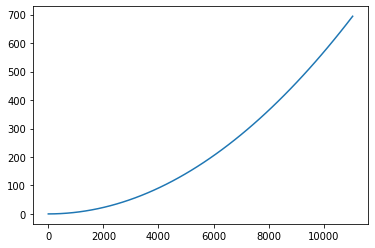

In [116]:
plt.plot(x0, z0)
plt.show()

In [117]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [118]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [119]:
V_rho

array([[6.0751987e+10, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.0751987e+10, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.0751987e+10]])

In [120]:
Jv(x0,[0 for i in range(len(z0))],z0,len(z0))

array([[11165.46734287,     0.        ,   708.46681953],
       [10939.90234605,     0.        ,   708.17797669],
       [10714.33734922,     0.        ,   707.31144627],
       [10488.7723524 ,     0.        ,   705.86722258],
       [10263.20735557,     0.        ,   703.84529616],
       [10037.64235875,     0.        ,   701.24565373],
       [ 9812.07736192,     0.        ,   698.06827826],
       [ 9586.51236509,     0.        ,   694.3131489 ],
       [ 9360.94736827,     0.        ,   689.98024102],
       [ 9135.38237144,     0.        ,   685.0695262 ],
       [ 8909.81737462,     0.        ,   679.58097223],
       [ 8684.25237779,     0.        ,   673.51454311],
       [ 8458.68738097,     0.        ,   666.87019906],
       [ 8233.12238414,     0.        ,   659.64789648],
       [ 8007.55738731,     0.        ,   651.84758802],
       [ 7781.99239049,     0.        ,   643.4692225 ],
       [ 7556.42739366,     0.        ,   634.51274497],
       [ 7330.86239684,     0. 

In [121]:
def Joma(J):
    return (J/(J.max(axis=0)+1e-6))[::-1]

In [122]:
def Joma_I(I):
    ans=[]
    for i in range(len(I)):
#         print(I[-1].diagonal()[0]/I[i].diagonal()[0])
        ans.append(I[-1].diagonal()/I[i].diagonal())
    return np.array(ans)

In [123]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [124]:
I511=Joma_I(Irho)

In [125]:
def Joma_M(I):
    ans=[]
    for i in range(len(I)):
        ans.append(I[-1]/I[i])
    return np.array(ans)

In [126]:
I511

array([[0.99999992, 0.99999992, 0.99999984],
       [0.99999992, 0.99999992, 0.99999984],
       [0.99999992, 0.99999992, 0.99999985],
       [0.99999992, 0.99999992, 0.99999985],
       [0.99999993, 0.99999993, 0.99999985],
       [0.99999993, 0.99999993, 0.99999986],
       [0.99999993, 0.99999993, 0.99999986],
       [0.99999993, 0.99999993, 0.99999986],
       [0.99999993, 0.99999993, 0.99999987],
       [0.99999993, 0.99999993, 0.99999987],
       [0.99999994, 0.99999994, 0.99999987],
       [0.99999994, 0.99999994, 0.99999987],
       [0.99999994, 0.99999994, 0.99999988],
       [0.99999994, 0.99999994, 0.99999988],
       [0.99999994, 0.99999994, 0.99999988],
       [0.99999994, 0.99999994, 0.99999989],
       [0.99999995, 0.99999995, 0.99999989],
       [0.99999995, 0.99999995, 0.99999989],
       [0.99999995, 0.99999995, 0.9999999 ],
       [0.99999995, 0.99999995, 0.9999999 ],
       [0.99999995, 0.99999995, 0.9999999 ],
       [0.99999995, 0.99999995, 0.99999991],
       [0.

In [127]:
M511=Joma_M(M_t)

In [128]:
# def mass(M, m, X,Y,Z):
  
#     M1=Jv(X,Y,Z,len(X))**2*M
# #     print(M1.shape)
# #     print((Jv(X,Y,Z,len(X))**2).shape)
#     M2=Jv(X,Y,Z,len(X))**2*m
    
#     return np.sum(M1+M2,axis=1)

In [129]:
# inert(vessel_mass*9.81,mp*9.81, x0).shape

In [130]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987 for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09 for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569 for i in range(node_N)])
#        q0[(j-1)*node_N]=0 
q0[7*node_N-1]= -0.00010522890316932987 # here
q0[9*node_N-1]= 6.952842745988619e-09
q0[11*node_N-1]=0.00010649100253301569 # here

In [131]:
I511.shape

(50, 3)

In [132]:
M511.shape

(50,)

In [133]:
Joma(Jv(x,y,z,len(z))).shape

(50, 3)

In [134]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
    
    Z0= - np.einsum('ijk,i->ij', Re_b(Ret), np.dot(I511, tau_force[:3].reshape(3,1)).squeeze())
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
#     print(M_t)
    
############################################################ 
#     print(Re_b(Ret).shape,M_t.shape)
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('ijk,ik->ij',Re_b(Ret),M_t),Z).T
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

#     sum_0123=0
#     lll=[]
#     for i in range(1,len(z0)):
#         sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         lll.append(sum_0123)
        
#     cum_d_inv=[0]
#     sum_=0
#     for i in range(len(lll)-1,-1,-1):
#         sum_+=lll[i]
#         cum_d_inv.append(sum_)
#     cum_d_inv=cum_d_inv[::-1] 
     
    
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    
    C0=-np.einsum('ijk,i->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), np.dot(I511,tau_force[:3].reshape(3,1)).squeeze()) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [135]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [136]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [137]:
root

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [138]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [139]:
q0=root

In [140]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [141]:
# x0_

In [142]:
# z0

In [143]:
# z0_

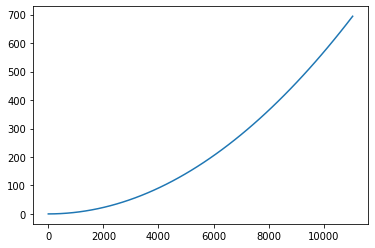

In [144]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [145]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [146]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [147]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [148]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [149]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [150]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [151]:
f

array([-1.00000000e+01, -3.83026943e-15,  2.00000000e+01,  4.20496971e-15,
        2.22044605e-16, -1.20736754e-15,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [152]:
def PipeForce(X,Y,Z,vessel_force, coef=1, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    global_force=np.zeros(len(X)*6) 
    global_force[-6:]=coef*np.array(vessel_force)
    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
#     print(d)    
 
    return np.array(fors), np.array(mom), np.array(angle)

In [153]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337],1e-10)

In [154]:
fors

array([[-6.63831440e-06, -8.86697261e-04, -1.36430018e-02],
       [-1.01954356e-09, -2.98310265e-10,  1.24102542e-08],
       [-2.23371899e-09, -1.03664504e-08,  3.64426000e-09],
       [-2.44472176e-09,  2.72962986e-10, -2.12818350e-08],
       [-3.95812094e-09,  2.31335946e-08,  3.98404154e-09],
       [-4.48198989e-09,  1.64216729e-09, -1.63840923e-08],
       [-5.99538907e-09, -4.10965342e-08, -7.79436959e-09],
       [-6.75208867e-09, -1.07316822e-09,  9.45692591e-09],
       [-8.38190317e-09,  2.19488889e-08, -1.08047971e-09],
       [-7.45058060e-09,  1.79593371e-08,  1.72731234e-08],
       [-6.51925802e-09,  1.56265401e-09,  8.92032403e-09],
       [-4.65661287e-09, -7.78890552e-09, -5.87897375e-09],
       [-3.25962901e-09, -3.75773368e-09, -1.04773790e-08],
       [ 9.31322575e-10,  2.78408123e-08, -2.01398507e-08],
       [-9.31322575e-10, -3.42851081e-10, -2.27009878e-09],
       [ 1.86264515e-09, -2.72248712e-08,  4.65661287e-10],
       [ 5.58793545e-09, -3.73952957e-09

### Vessle Simulation

In [155]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [156]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [157]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [158]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

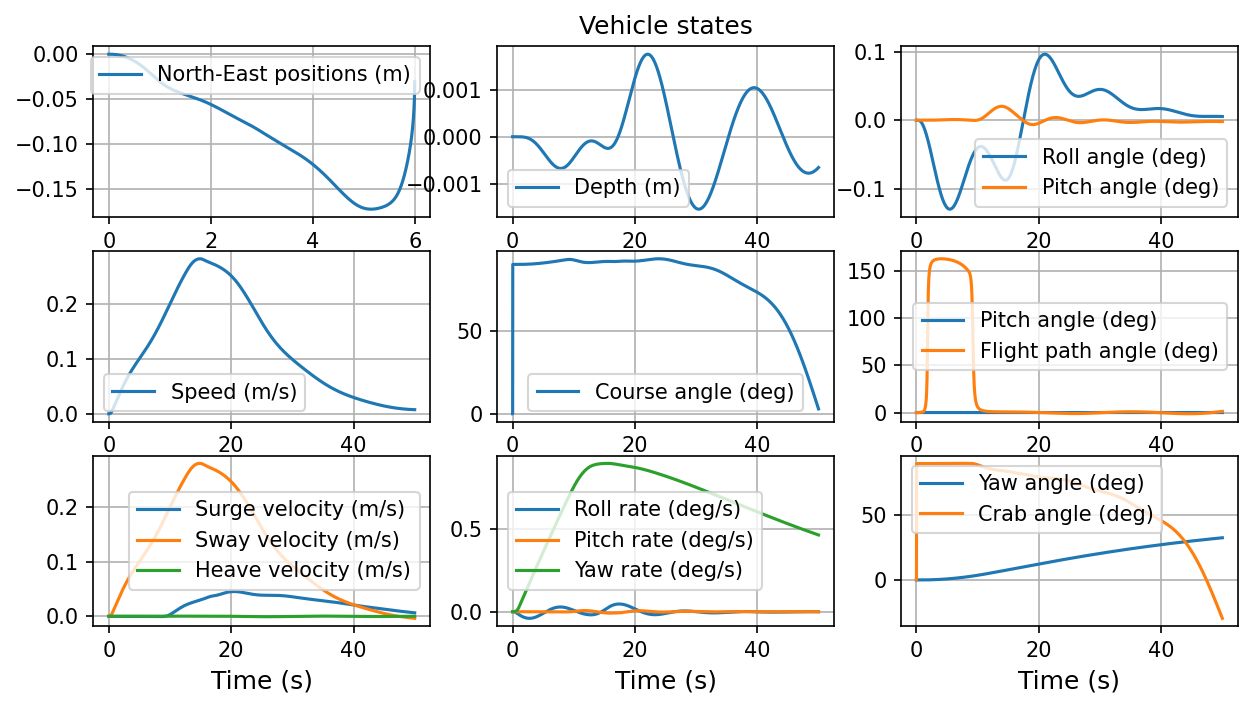

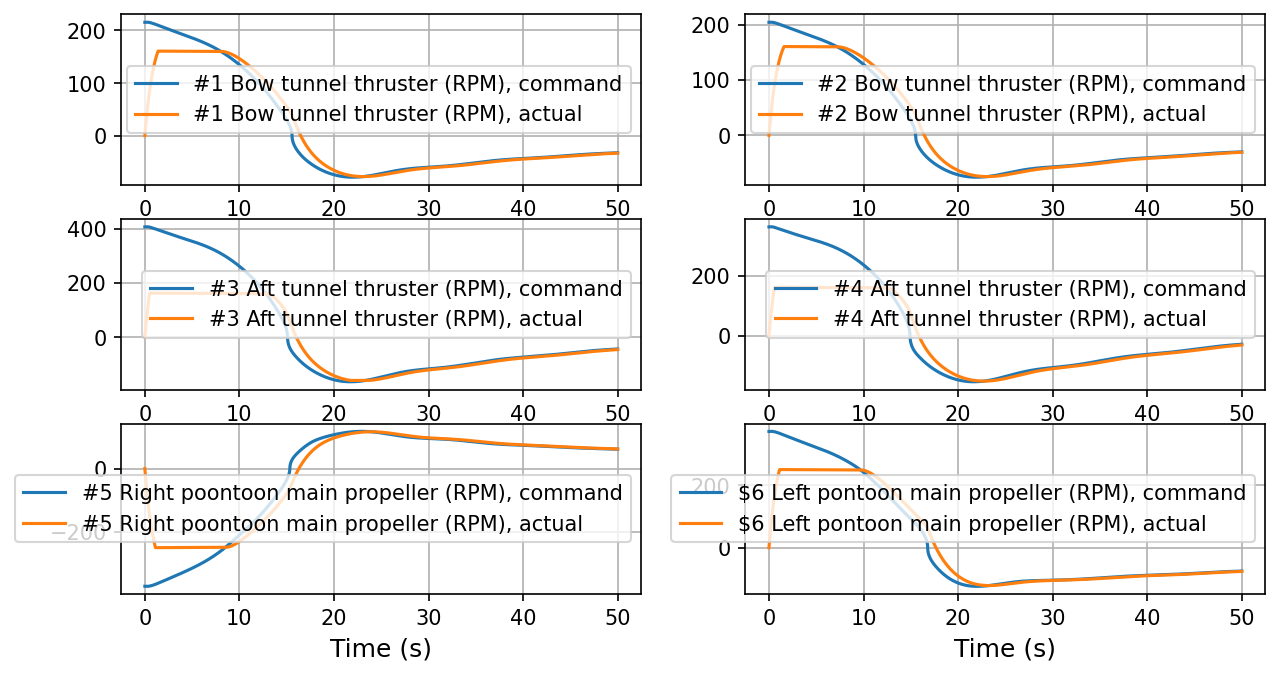

In [159]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [160]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

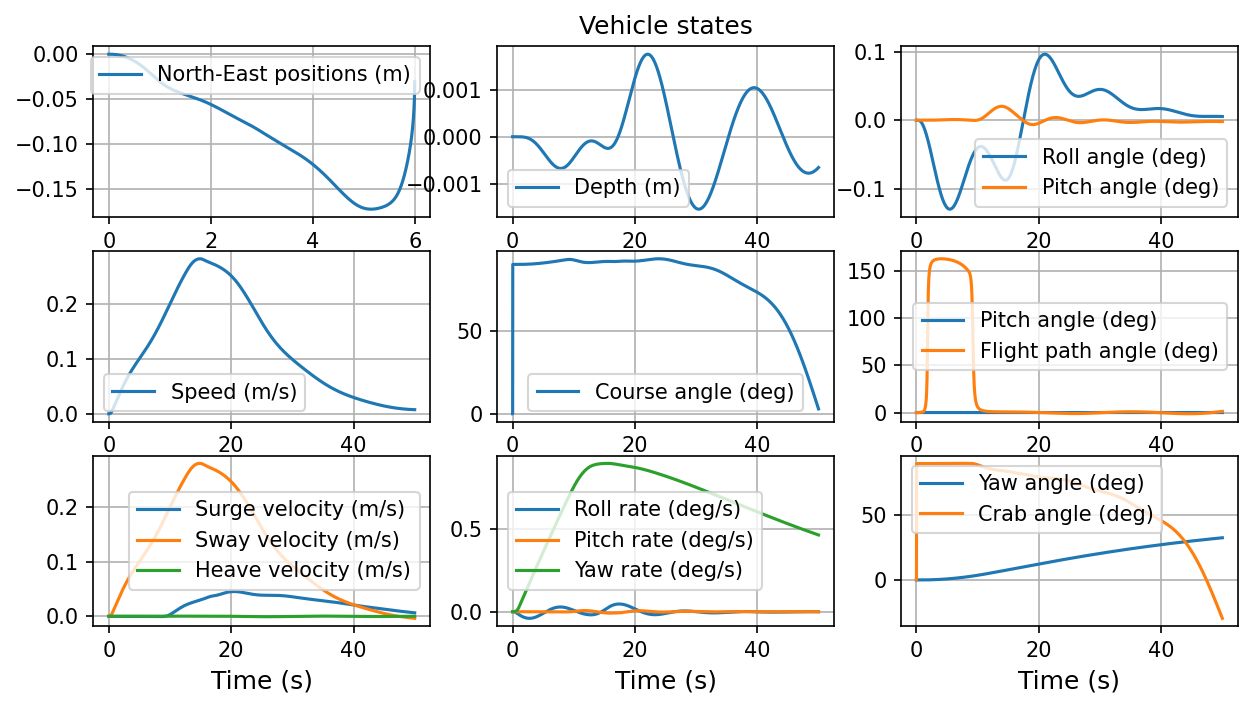

In [161]:
plotVehicleStates(simTime, simData, 3)

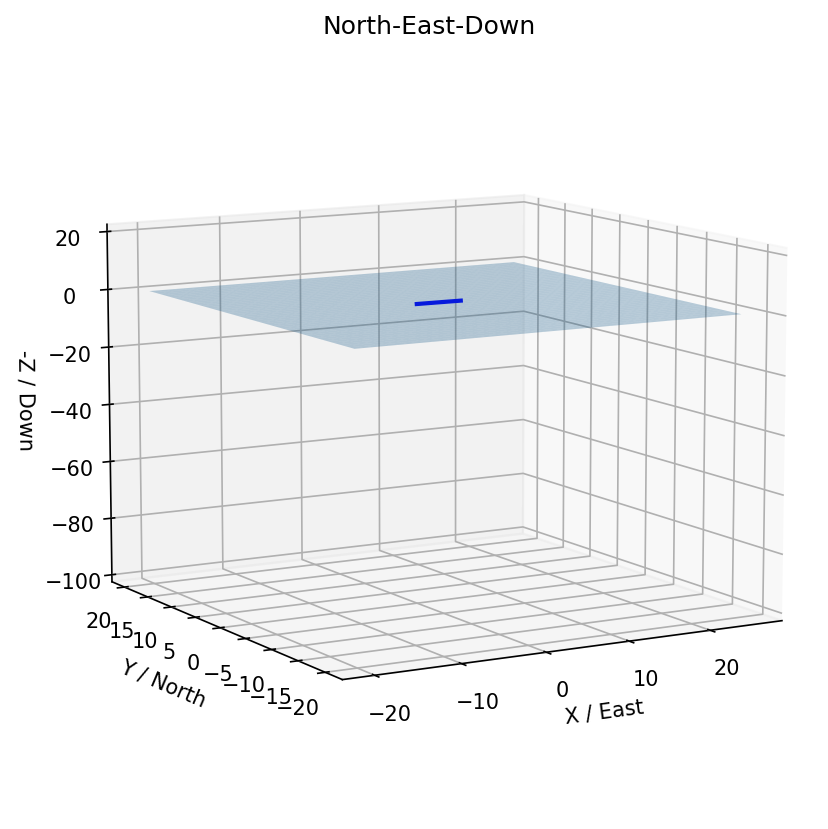

In [162]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [163]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [164]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [165]:
# Ws[0]*Ret[2]

In [166]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [167]:
idx=1/0.01

In [168]:
idx

100.0

In [169]:
ssa(simData[:, 3][int(idx)])

-0.00010522890316932987

In [170]:
ssa(simData[:, 4][int(idx)])

6.952842745988619e-09

In [171]:
ssa(simData[:, 5][int(idx)])

0.00010649100253301569

In [172]:
idx=int(idx)

In [173]:
x_ve = simData[:, 0][idx]
y_ve = simData[:, 1][idx]
z_ve = simData[:, 2][idx]
phi_ve = ssa(simData[:, 3][idx])
theta_ve = ssa(simData[:, 4][idx])
psi_v = ssa(simData[:, 5][idx])


u_ve = simData[:, 6][idx]
v_ve = simData[:, 7][idx]

w_ve = simData[:, 8][idx]
p_ve = simData[:, 9][idx]
q_ve = simData[:, 10][idx]
r_ve = simData[:, 11][idx]

In [174]:
η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])

In [175]:
n_ = myDPcontrol(vehicle,η,dη,sampleTime)

In [176]:
x,y,z=q0[0:node_N],q0[2*node_N:3*node_N],q0[4*node_N:5*node_N]

In [177]:
fors, mom, angle = PipeForce(x,y,z,n_)

In [178]:
angle

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.43320146e+03, -3.20292086e+05,  2.08167510e+04],
       [-2.85220747e+03, -6.34007507e+05,  4.12053988e+04],
       [-4.25620078e+03, -9.41148203e+05,  6.11661314e+04],
       [-5.64436424e+03, -1.24171598e+06,  8.06991267e+04],
       [-7.01588090e+03, -1.53571250e+06,  9.98045602e+04],
       [-8.36993374e+03, -1.82313932e+06,  1.18482597e+05],
       [-9.70570542e+03, -2.10399786e+06,  1.36733376e+05],
       [-1.10223783e+04, -2.37828939e+06,  1.54557026e+05],
       [-1.23191347e+04, -2.64601508e+06,  1.71953679e+05],
       [-1.35951571e+04, -2.90717597e+06,  1.88923463e+05],
       [-1.48496273e+04, -3.16177296e+06,  2.05466488e+05],
       [-1.60817268e+04, -3.40980683e+06,  2.21582851e+05],
       [-1.72906365e+04, -3.65127821e+06,  2.37272632e+05],
       [-1.84755370e+04, -3.88618762e+06,  2.52535914e+05],
       [-1.96356085e+04, -4.11453542e+06,  2.67372769e+05],
       [-2.07700301e+04, -4.33632188e+06

### Dynamics

In [179]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
#     force_schedule=1e-4
    force_schedule=1e-12
#     force_schedule=0
#     print(type(n_))
#     tau_force = force_schedule*np.array(n_) # [N]
    
    fors, mom, angle = PipeForce(x,y,z,n_,force_schedule)
    
    φ,θ,ψ=angle.T
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0
#     print(tau_force.astype(np.float64))

#     sum_0123=0
#     lll=[]
#     for i in range(1,len(z0)):
#         sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
#         lll.append(sum_0123)

    
#     cum_d_inv=[0]
#     sum_=0
#     for i in range(len(lll)-1,-1,-1):
#         sum_+=lll[i]
#         cum_d_inv.append(sum_)
#     cum_d_inv=cum_d_inv[::-1]   

#     print(np.dot(1/(Jv(x,y,z,len(z))+1e-3),tau_force[:3].reshape(3,1)).squeeze())
#     print(tau_force[:3])
#     Z0=-np.einsum('ijk,ik->ij', Re_b(Ret), np.einsum('i,k->ik',cum_d_inv[::-1],tau_force[:3])/max(cum_d_inv))
    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

#     Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     Z0=-tau_force[:3]
#     print(Ret)
#     print(Z0.shape)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    haka=1
    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T
#     ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
    
    
#     ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
# #                                              [Ws[i] for i in range(node_N)]
# #                                              +[Ws[-1] + vessel_mass]
#                                              haka*M_totl
                                          
#                                              ,RRRR),
#                                    Z
#                                   ).T 
# #     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      


#     print(cum_d_inv[0])
#     Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
#     A2 = Irho_e(Ret,Irho).astype(np.float64)
#     A3=Π(φ,θ,ψ).astype(np.float64)

#     A=np.einsum('ijk,ikr->ijr',A2,A3)
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [180]:
# import scipy

In [181]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [182]:
# us=ode15s.integrate(10)

In [183]:
tspan = (0., 50)

In [184]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:05.580957


In [185]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init), force_schedule, hak and haka

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [186]:
fin=us

In [187]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 128
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.11123936,  0.98708527,  2.19111903,  3.68902633,
        5.59379828,  8.10284257, 11.13260072, 13.68408553, 16.23557033,
       19.04520508, 22.14310663, 25.42206266, 28.6437515 , 31.81082115,
       35.03500047, 38.34963868, 41.67511346, 44.93342657, 48.14818753,
       50.        ])
 t_events: None
        y: array([[ 0.00000000e+00,  1.29575486e-16,  1.05821957e-14, ...,
         3.94805311e-11,  4.11805488e-11,  4.21126112e-11],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         2.25564995e+02,  2.25564995e+02,  2.25564995e+02],
       [ 4.51129994e+02,  4.51129994e+02,  4.51129994e+02, ...,
         4.51129983e+02,  4.51129982e+02,  4.51129982e+02],
       ...,
       [ 0.00000000e+00,  9.50944385e-06,  5.48227023e-05, ...,
        -1.42019074e-06, -3.36273596e

In [188]:
t=fin.t

In [189]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


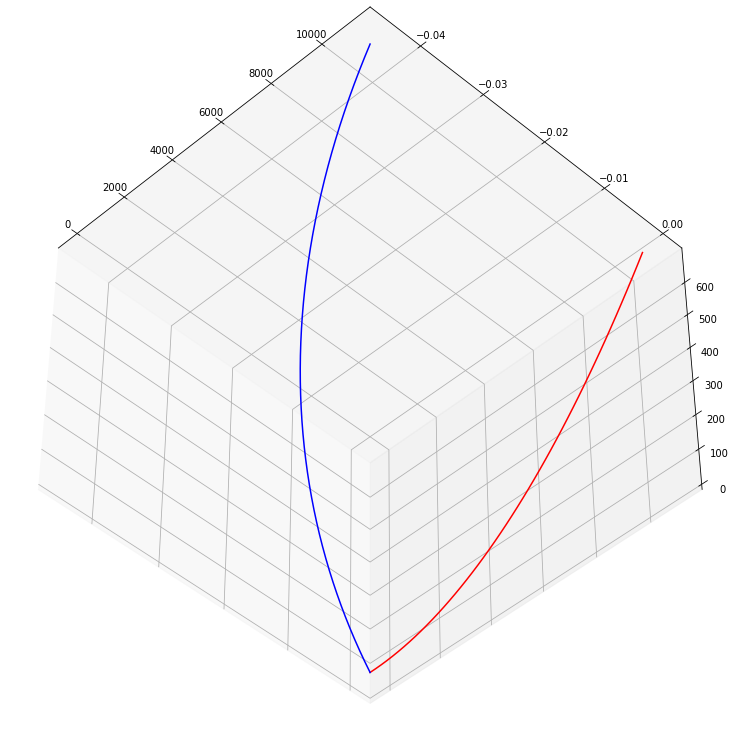

In [190]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [191]:
X,Y,Z

(array([4.21126112e-11, 2.25564995e+02, 4.51129982e+02, 6.76694951e+02,
        9.02259896e+02, 1.12782481e+03, 1.35338969e+03, 1.57895452e+03,
        1.80451931e+03, 2.03008404e+03, 2.25564872e+03, 2.48121334e+03,
        2.70677790e+03, 2.93234239e+03, 3.15790683e+03, 3.38347119e+03,
        3.60903549e+03, 3.83459973e+03, 4.06016390e+03, 4.28572800e+03,
        4.51129205e+03, 4.73685603e+03, 4.96241995e+03, 5.18798382e+03,
        5.41354763e+03, 5.63911139e+03, 5.86467510e+03, 6.09023877e+03,
        6.31580240e+03, 6.54136600e+03, 6.76692956e+03, 6.99249310e+03,
        7.21805661e+03, 7.44362011e+03, 7.66918360e+03, 7.89474708e+03,
        8.12031056e+03, 8.34587405e+03, 8.57143755e+03, 8.79700106e+03,
        9.02256459e+03, 9.24812815e+03, 9.47369175e+03, 9.69925538e+03,
        9.92481906e+03, 1.01503828e+04, 1.03759466e+04, 1.06015104e+04,
        1.08270743e+04, 1.10526383e+04]),
 array([ 7.54451415e-10, -1.77160411e-03, -3.50766064e-03, -5.20812499e-03,
        -6.8729570

In [192]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [193]:
us=fin.T

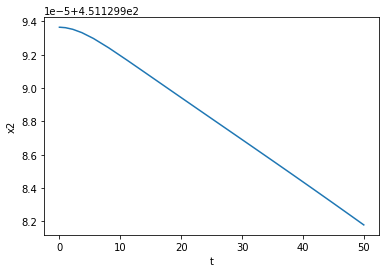

In [194]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

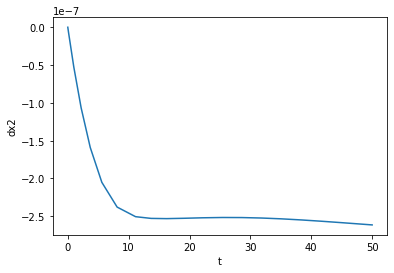

In [195]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

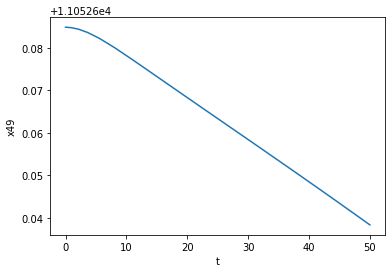

In [196]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

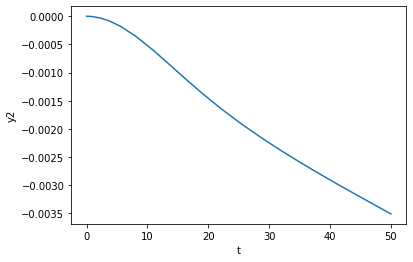

In [197]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

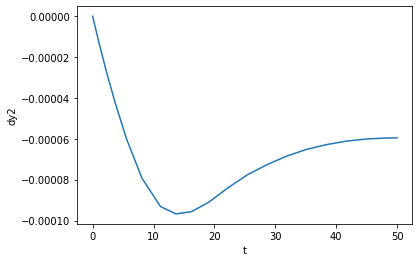

In [198]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

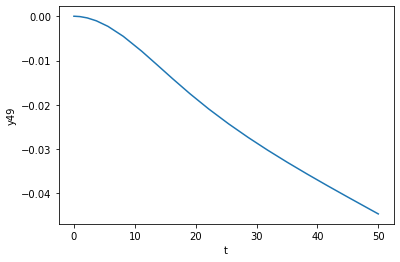

In [199]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

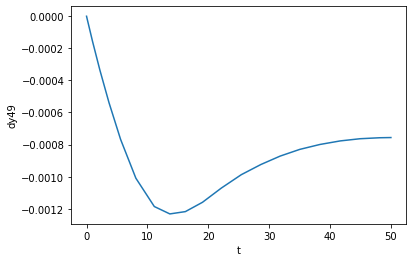

In [200]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

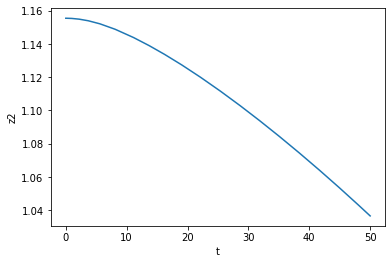

In [201]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

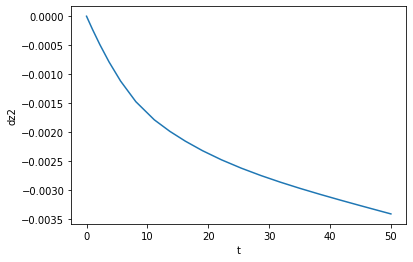

In [202]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

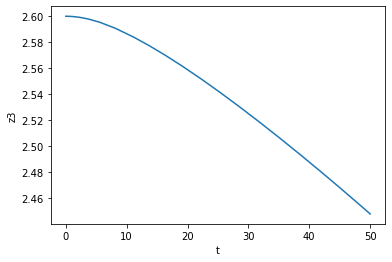

In [203]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

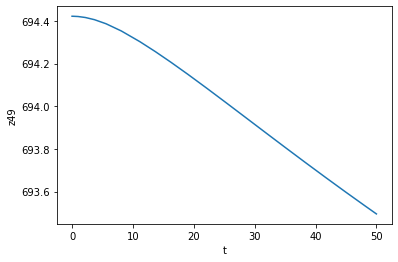

In [204]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

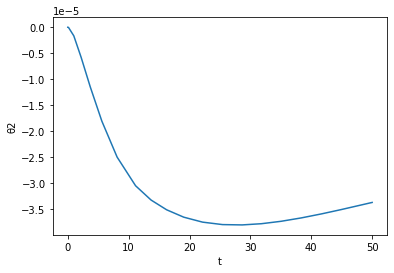

In [205]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

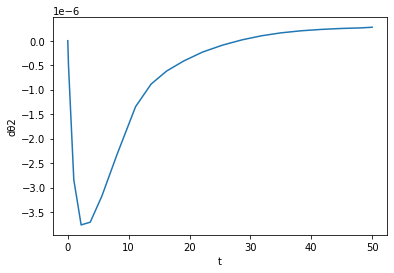

In [206]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

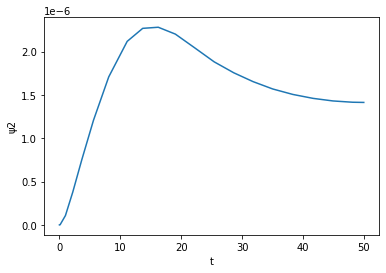

In [207]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

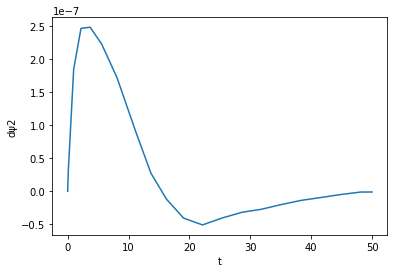

In [208]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()